### Importing necessary libs

In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import silhouette_score
from scipy.optimize import curve_fit

### Reading generated data

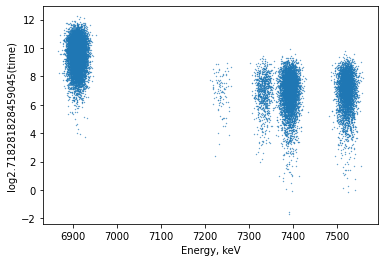

In [2]:
# Reading generated data 
primary_nucleus = '215Th'
num_of_gens = 10000

a = np.exp(1)

with open(f'{primary_nucleus}_{num_of_gens}_ms.txt', 'r') as f:
    file_data = f.read()
time, energy = file_data.split('\n')
theta = [np.log(float(el)) / np.log(a) for el in time.split(',')]
energy = [float(el) for el in energy.split(',')]

fig, ax = plt.subplots()
plt.xlabel('Energy, keV')
plt.ylabel(f'log{a}(time)')
ax.scatter(energy, theta, s=0.1)

### Format data to pandas.DataFrame

In [3]:
db = pd.DataFrame({
    'theta': theta,
    'energy': energy
})

db.head()

,theta,energy
0,7.572511,7514.426
1,8.625626,6903.130
2,5.197377,7505.484
3,8.682133,6904.617
4,7.476203,7528.338


## Evaluating number of clusters

This approach is based on calculating [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). The main idea is that silhouette score is calculated in the loop for different number of clusters. The point right before the biggest downturn is the real number of clusters.

I modified this approach in the next way: 
It's much better to control downturn by derivative. 
Also we can find the biggest downturn by finding outlier in list of derivatives.

#### silhouette score calculations

In [4]:
num_of_clusters = range(2,13)

silhouette_avg = []
for num_clusters in num_of_clusters:

    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(db[['energy', 'theta']])
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(db[['energy', 'theta']], cluster_labels))

#### calculatiions derivative of silhouette score

In [5]:
derivative_silhouette_avg = [silhouette_avg[i + 1] - silhouette_avg[i] for i in range(len(silhouette_avg) - 1)]

#### visualising

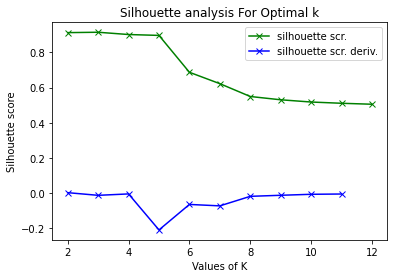

In [6]:
plt.plot(num_of_clusters, silhouette_avg, 'gx-', label='silhouette scr.')
plt.plot(num_of_clusters[:-1],derivative_silhouette_avg,'bx-', label='silhouette scr. deriv.')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.legend()
plt.show()

####  finding outlier in silhouette score derivative

In [7]:
def outlier_finder(x):
    mean_x = np.mean(x)
    sd_x = np.std(x)
    dev_x = abs(x - mean_x)
    max_dev_x = max(dev_x)
    if max_dev_x > (1.5 * sd_x):
        return np.where(dev_x == max_dev_x)[0][0]
    else:
        return None # if no outlier, the number of clusters is 1

### Let's apply this approach to our dataset

(probably it will be convolved into one function that has dataset as input and num of clusters as output)

5


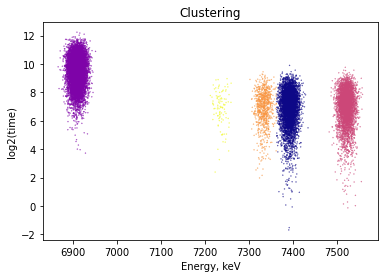

In [8]:
num_of_clusters = range(2,13)

silhouette_avg = []
for n in num_of_clusters:

    kmeans = KMeans(n_clusters=n)
    kmeans.fit(db[['energy', 'theta']])
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(db[['energy', 'theta']], cluster_labels))
    
derivative_silhouette_avg = [silhouette_avg[i + 1] - silhouette_avg[i] for i in range(len(silhouette_avg) - 1)]

outlier = outlier_finder(derivative_silhouette_avg)

if outlier:
    real_number_of_clusters = num_of_clusters[outlier]
else:
    real_number_of_clusters = 1
    
print(real_number_of_clusters)
    
kmeans = KMeans(n_clusters=real_number_of_clusters)
kmeans.fit(db[['energy', 'theta']])

db['labels'] = kmeans.labels_

fig, ax = plt.subplots()
ax.scatter(db.energy, db.theta, c=db['labels'], cmap="plasma", s=0.1)
plt.title('Clustering')
plt.xlabel('Energy, keV')
plt.ylabel('log2(time)')
plt.show()

### Fitting function
The approximation function is the product of Gaussian and time distribution 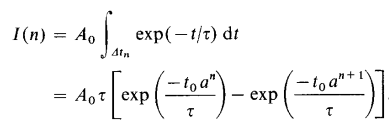
As primary parameters we use center of cluster that we are able to extract from kmeans


In [9]:
def fit_func_3d(en, *pars, c, a):
    result = 0

    for i in range(c):
        a0 = pars[4 * i]
        tau = pars[4 * i + 1]
        mu = pars[4 * i + 2]
        sigma = pars[4 * i + 3]
        # result = amplitude * \
        # time distribution * \
        # gaussian
        result += a0 * \
        np.log(a) * np.exp(en[:,1] * np.log(a)) * np.exp((- np.exp(en[:,1] * np.log(a))) / tau) *\
        (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(en[:,0] - mu) ** 2 / (2 * sigma ** 2)) 
    return result

In [10]:
kmeans.cluster_centers_

array([[7.39189071e+03, 6.86757898e+00],
       [6.90897277e+03, 9.50186479e+00],
       [7.52185566e+03, 6.91482411e+00],
       [7.33363824e+03, 6.88706904e+00],
       [7.23593005e+03, 6.86499436e+00]])

### Preparing data for fitting 
I decided to make two-dimensional histogram and then fit its points 

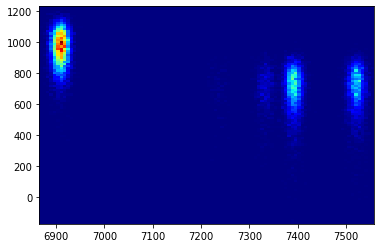

In [11]:
energy = db['energy']
new_a = 1.01
theta = [el * np.log(a) / np.log(new_a) for el in db['theta']]

data = np.array([list(el) for el in zip(energy, theta)])

hist, energy_bins_edges, theta_bins_edges, im = plt.hist2d(data[:,0], data[:,1], bins=(100, 100), cmap=plt.cm.jet)

In [12]:
energy_bins = np.array([(energy_bins_edges[i] + energy_bins_edges[i + 1]) / 2 for i in range(len(energy_bins_edges) - 1)]).flatten().astype(np.float64)
theta_bins = np.array([(theta_bins_edges[i] + theta_bins_edges[i + 1]) / 2 for i in range(len(theta_bins_edges) - 1)]).flatten().astype(np.float64)

energytheta_data = np.array([(energy_bins[i], theta_bins[j]) for i in range(len(energy_bins)) for j in range(len(theta_bins))])

counts = np.array([hist[i][j] for i in range(len(energy_bins)) for j in range(len(theta_bins))]).flatten().astype(np.float64)

In [13]:
p0 = []
c = len(kmeans.cluster_centers_)
for center in kmeans.cluster_centers_:
    en_center, n_center = center
    a0 = db[db['labels'] == np.where(kmeans.cluster_centers_ == center)[0][0]].shape[0] 
    tau_0 = np.power(a, n_center)
    [p0.append(el) for el in [a0, tau_0, en_center, 15]]
    
    
popt, pcov = curve_fit(lambda en, *pars: fit_func_3d(en, *pars, c=c, a=new_a), energytheta_data, counts, p0=p0)

errors = np.sqrt(np.diag(pcov))
print(popt, np.sqrt(np.diag(pcov)))

[2.97468190e+02 1.67170102e+03 7.39160529e+03 1.07626288e+01
 5.30044261e+01 1.95894337e+04 6.90919912e+03 1.09624420e+01
 2.15653763e+02 1.78989450e+03 7.52191048e+03 1.07233882e+01
 4.75274352e+01 1.65187463e+03 7.33346366e+03 1.11959355e+01
 6.58731009e+00 1.45798914e+03 7.23508800e+03 1.08311328e+01] [2.15670862e+00 9.15725635e+00 5.89853065e-02 5.91038908e-02
 1.85648020e-01 5.18675740e+01 2.90250676e-02 2.90250996e-02
 2.00959351e+00 1.26082724e+01 7.55373915e-02 7.55413193e-02
 2.22607491e+00 5.84564592e+01 3.96389956e-01 3.97210634e-01
 2.47952731e+00 4.14769328e+02 3.08104942e+00 3.08104942e+00]


### Results
As we see, the obtained energy values agree well, but the half-life values are markedly different.
Modeled energies are 7522, 6909, 7392, 7236 and 7334 keV.
Modeled half life times are 1.2 and 13 second.

In [14]:
fitting_results = pd.DataFrame({'half life time':[np.log(2) * popt[4 * i + 1] for i in range(real_number_of_clusters)],
                               'half life time error':[np.log(2) * errors[4 * i + 1] for i in range(real_number_of_clusters)],
                               'energy':[popt[4 * i + 2] for i in range(real_number_of_clusters)],
                               'energy error':[errors[4 * i + 2] for i in range(real_number_of_clusters)],
                               'fwhm':[2.355 * popt[4 * i + 3] for i in range(real_number_of_clusters)],
                               'fwhm error':[2.355 * errors[4 * i + 3] for i in range(real_number_of_clusters)],})
fitting_results

,half life time,half life time error,energy,energy error,fwhm,fwhm error
0,1158.734850,6.347326,7391.605290,0.058985,25.345991,0.139190
1,13578.360756,35.951863,6909.199121,0.029025,25.816551,0.068354
2,1240.660328,8.739388,7521.910482,0.075537,25.253579,0.177900
3,1144.992241,40.518930,7333.463655,0.396390,26.366428,0.935431
4,1010.601061,287.496190,7235.088004,3.081049,25.507318,7.255871


### Relative errors

In [19]:
compairing = fitting_results[['half life time', 'half life time error']].copy()
compairing['real half life time'] = [1200, 13000, 1200, 1200, 1200]
compairing['relative error, %'] = 100 * abs(compairing['half life time'] - 
                                      compairing['real half life time']) / compairing['real half life time']
compairing['falls within the error interval'] = (compairing['real half life time'] > compairing['half life time'] - compairing['half life time error']) & (compairing['real half life time'] < compairing['half life time'] + compairing['half life time error'])

compairing

,half life time,half life time error,real half life time,"relative error, %",falls within the error interval
0,1158.734850,6.347326,1200,3.438762,False
1,13578.360756,35.951863,13000,4.448929,False
2,1240.660328,8.739388,1200,3.388361,False
3,1144.992241,40.518930,1200,4.583980,False
4,1010.601061,287.496190,1200,15.783245,True


### Trying to fit one energy and hktime of one cluster separately

In [16]:
def time_fit_func(n, *pars):
    t_0 = 1
    a0, tau = pars
    return a0 * (np.exp(-t_0 * np.power(a, n) / tau) - np.exp(-t_0 * np.power(a, n + 1) / tau))

def energy_fit_func(e, *pars):
    a, mu, sigma = pars
    return a * np.exp(-(en[:,0] - mu) ** 2 / (2 * sigma ** 2))

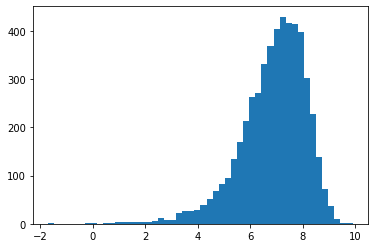

In [17]:
cluter_1_theta = db[db['labels'] == 0].theta
cluster_1_energy = db[db['labels'] == 0].energy

counts, theta_bins_edges, _ = plt.hist(cluter_1_theta, bins=50)
theta_bins = [(theta_bins_edges[i] + theta_bins_edges[i + 1]) / 2 for i in range(len(theta_bins_edges) - 1)]

[1213.33890442 2751.79843478] [ 9.10523455 30.97446655]
[ 841.02244066 1907.40132654]


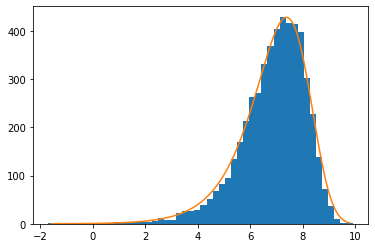

In [18]:
popt_theta, pocv_theta = curve_fit(lambda x, *pars: time_fit_func(x, *pars), theta_bins, counts, p0=[10000, 20000])
print(popt_theta, np.sqrt(np.diag(pocv_theta)))
plt.hist(cluter_1_theta, bins=50)
plt.plot(np.linspace(min(theta_bins), max(theta_bins), 10000), [time_fit_func(el, *popt_theta) for el in np.linspace(min(theta_bins), max(theta_bins), 10000)])
print(popt_theta * np.log(2))